In [147]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 150)

df = pd.read_csv('../data/plays_with_passer_expanded_with_z_norm.csv', low_memory=False)
df.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,...,pass_forward_frame,ball_snap_frame,play_direction,frames_to_pass,seconds_since_pass,los_norm,start_x_norm,end_x_norm,start_y_norm,end_y_norm
0,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,...,36,11,left,25,2.5,40,33.10,46.71,26.33,6.83
1,2018090600,146,(13:10) M.Ryan pass incomplete short right to ...,1,1,10,ATL,play_type_pass,PHI,39,...,31,11,left,20,2.0,40,34.39,43.69,23.62,16.91
2,2018090600,168,(13:05) (Shotgun) M.Ryan pass incomplete short...,1,2,10,ATL,play_type_pass,PHI,39,...,34,11,left,23,2.3,40,34.49,37.41,24.64,47.49
3,2018090600,190,(13:01) (Shotgun) M.Ryan pass deep left to J.J...,1,3,10,ATL,play_type_pass,PHI,39,...,39,11,left,28,2.8,40,30.60,61.83,26.24,41.47
4,2018090600,256,(10:59) (Shotgun) M.Ryan pass incomplete short...,1,3,1,ATL,play_type_pass,PHI,1,...,31,11,left,20,2.0,40,33.52,41.95,28.86,10.88


In [148]:
df.columns

Index(['gameId', 'playId', 'playDescription', 'quarter', 'down', 'yardsToGo',
       'possessionTeam', 'playType', 'yardlineSide', 'yardlineNumber',
       'offenseFormation', 'personnelO', 'defendersInTheBox',
       'numberOfPassRushers', 'personnelD', 'typeDropback',
       'preSnapVisitorScore', 'preSnapHomeScore', 'gameClock',
       'absoluteYardlineNumber', 'penaltyCodes', 'penaltyJerseyNumbers',
       'passResult', 'offensePlayResult', 'playResult', 'epa', 'isDefensivePI',
       'passer', 'v', 'vxy', 'vz', 'launch_angle', 'air_time', 'z_max',
       'distance', 'start_x', 'start_y', 'end_x', 'end_y',
       'pass_arrived_frame', 'pass_forward_frame', 'ball_snap_frame',
       'play_direction', 'frames_to_pass', 'seconds_since_pass', 'los_norm',
       'start_x_norm', 'end_x_norm', 'start_y_norm', 'end_y_norm'],
      dtype='object')

In [149]:
df['air_x_yards'] = np.abs(df.end_x-df.start_x)
df['air_frames'] = df.pass_arrived_frame-df.pass_forward_frame
df = df.loc[(df.air_frames>0) & (df.distance>0)]

In [ ]:
# P(t) section

<AxesSubplot:>

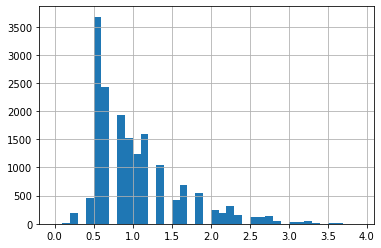

In [150]:
df.air_time.hist(bins=list(0.1*x for x in range(0, 40))) #air_frame has float binning issues... using integer frame values instead

<AxesSubplot:>

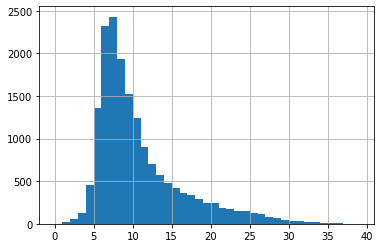

In [151]:
df.air_frames.hist(bins=list(1*x for x in range(0, 40)))

In [153]:
df.frames_to_pass.quantile([0.005, 0.01, 0.05, 0.1, 0.9, 0.95, 0.99, 0.995])

0.005     8.0
0.010    10.0
0.050    14.0
0.100    17.0
0.900    39.0
0.950    47.0
0.990    63.0
0.995    71.0
Name: frames_to_pass, dtype: float64

In [158]:
# consider ~98% of all passes-> range 8-71
frame_min = 10
frame_max = 63
filt_df = df.loc[(df.frames_to_pass>=frame_min)&(df.frames_to_pass<=frame_max)]

9.643100596923537 2.812511389784083


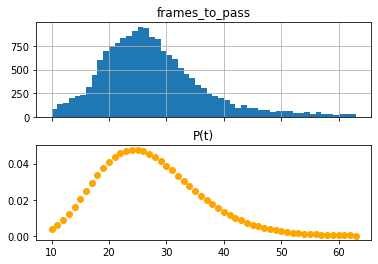

In [223]:
# P(t)
import scipy.stats as stats
fig, axs = plt.subplots(2, sharex=True)
filt_df.hist(column='frames_to_pass', bins=list(1*x for x in range(frame_min, frame_max+1)), ax=axs[0])

fit_alpha, fit_loc, fit_theta = stats.gamma.fit(filt_df.frames_to_pass.to_numpy(), floc=0)
print(fit_alpha, fit_theta)
x = np.linspace(frame_min, frame_max, 1+frame_max-frame_min)
y2 = stats.gamma.pdf(x, a=fit_alpha, loc=fit_loc, scale=fit_theta)
axs[1].scatter(x, y2, color='orange')
axs[1].set_title('P(t)')
plt.show()

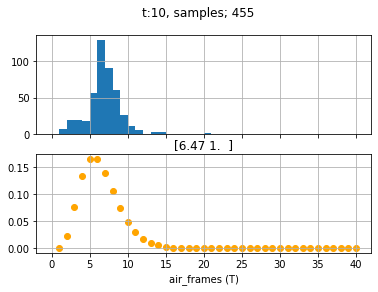

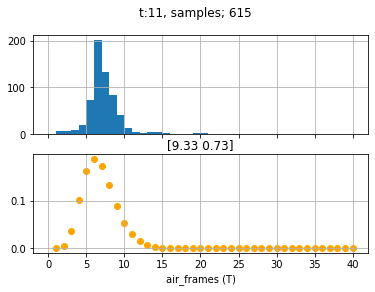

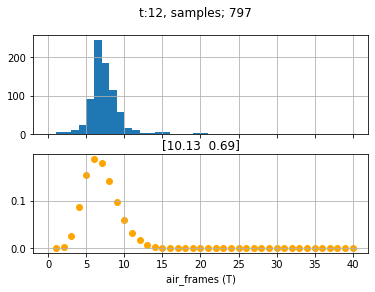

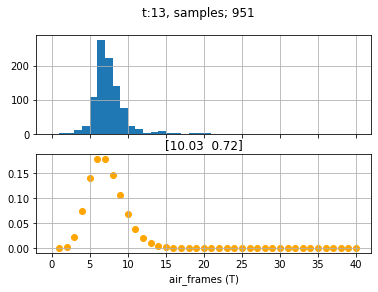

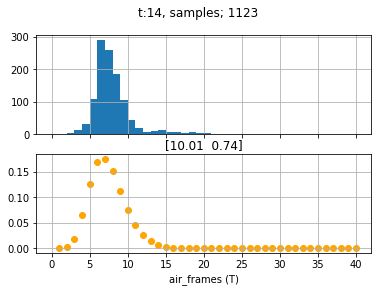

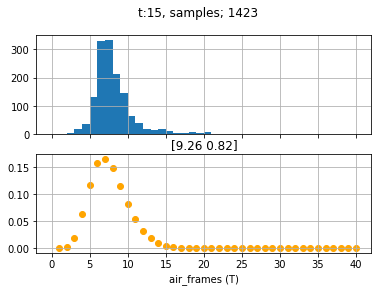

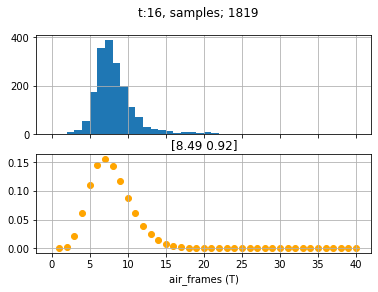

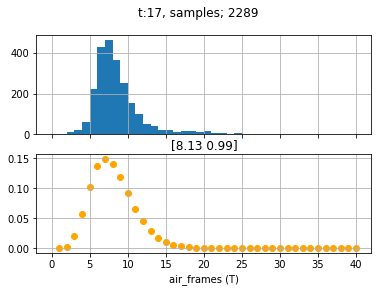

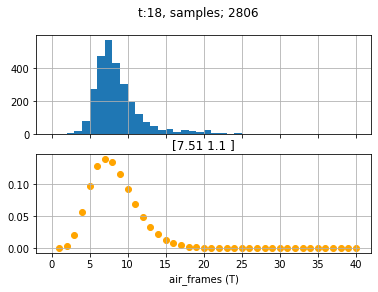

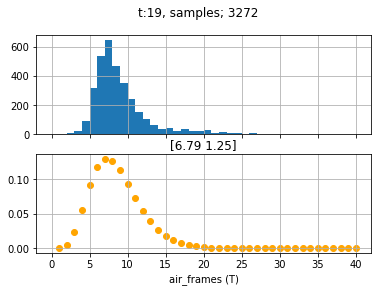

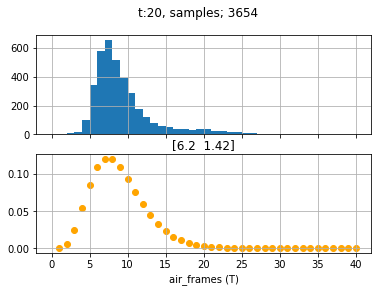

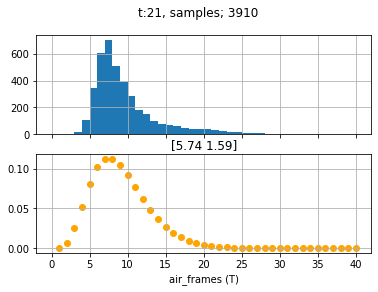

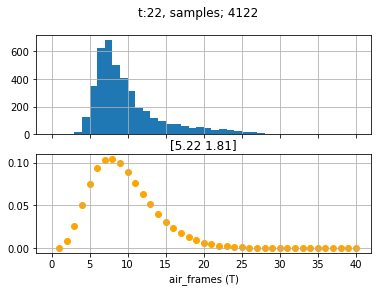

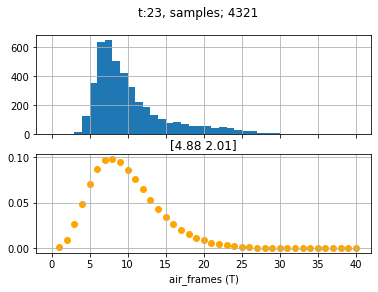

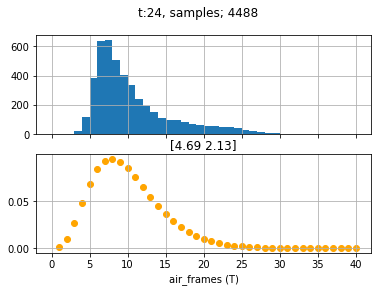

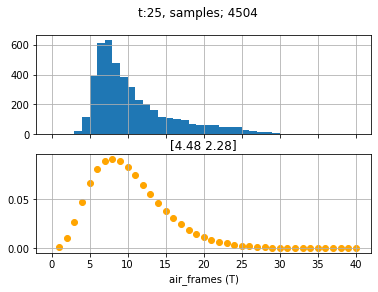

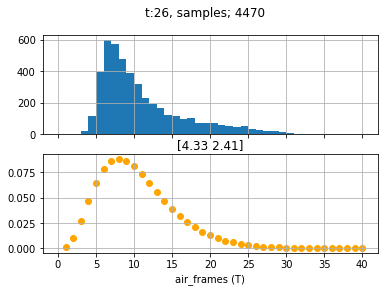

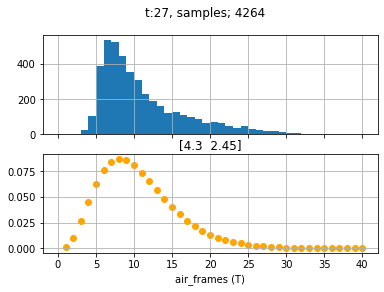

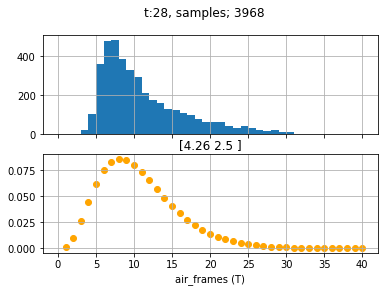

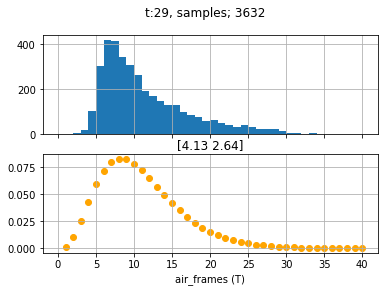

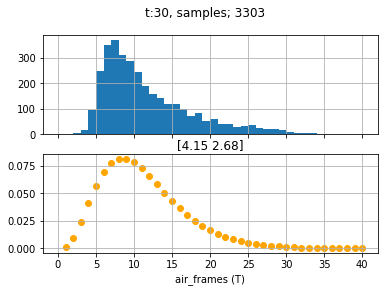

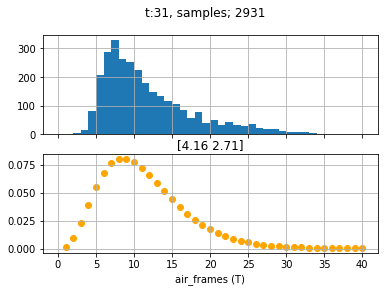

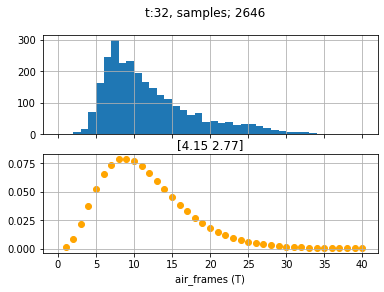

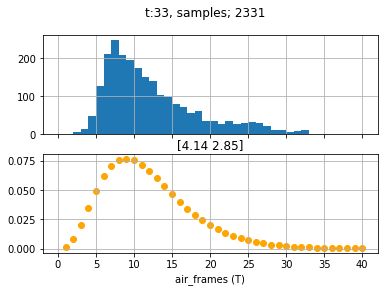

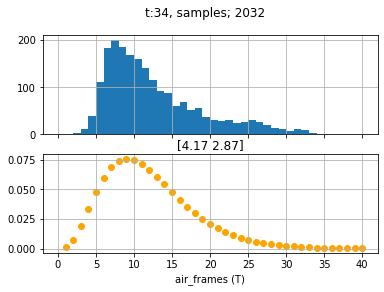

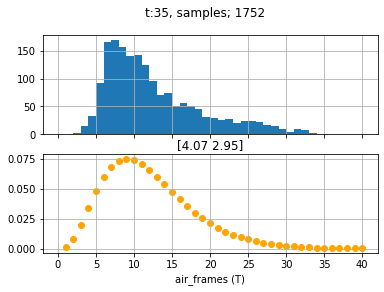

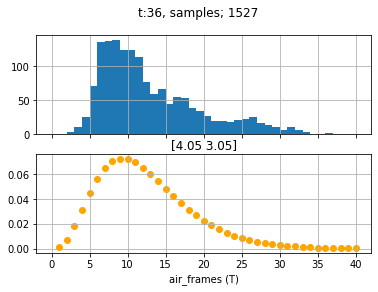

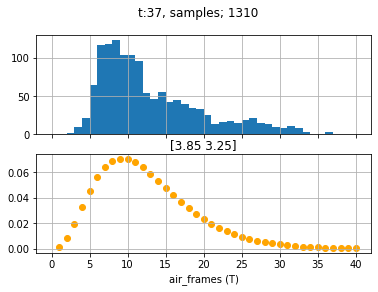

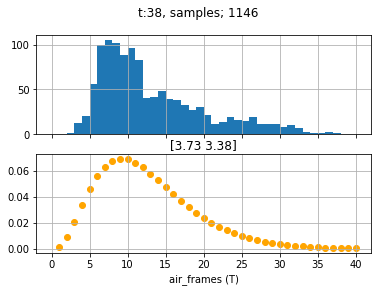

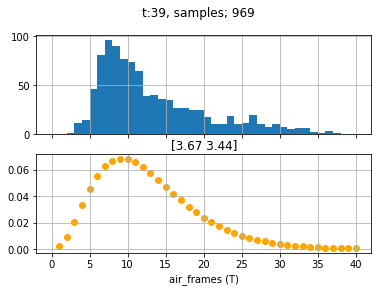

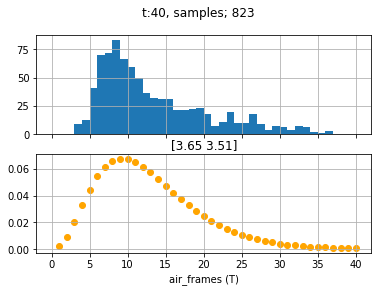

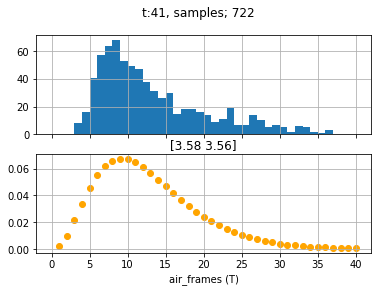

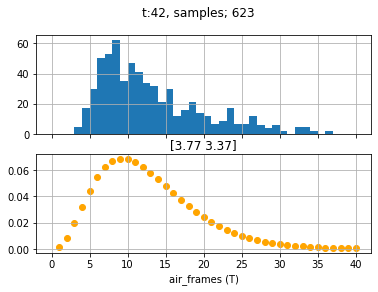

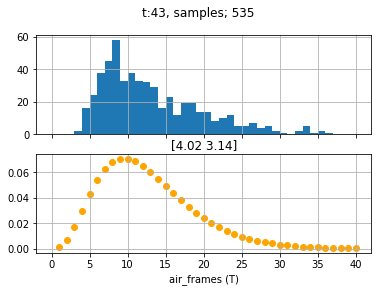

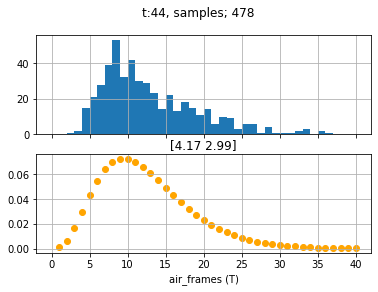

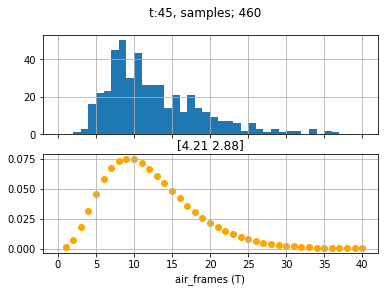

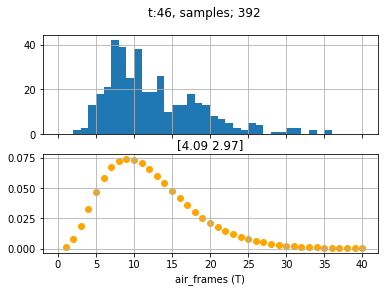

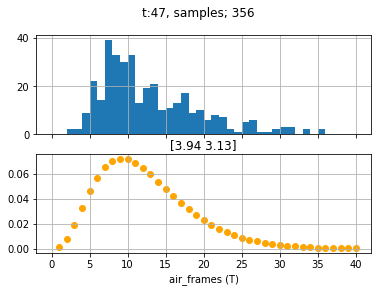

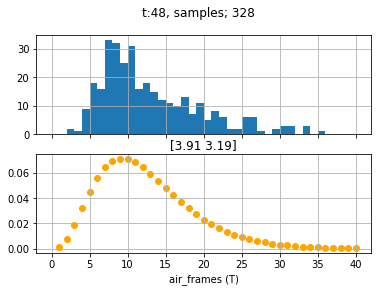

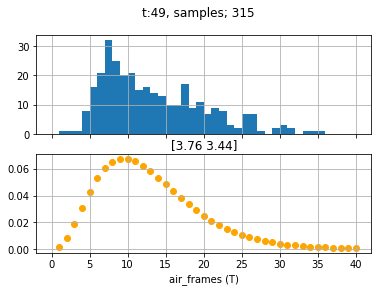

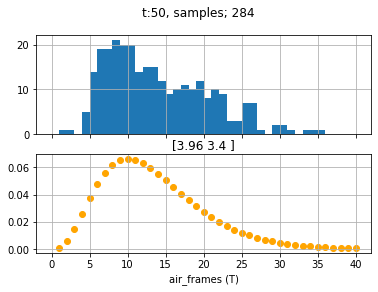

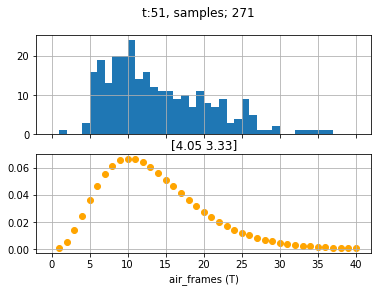

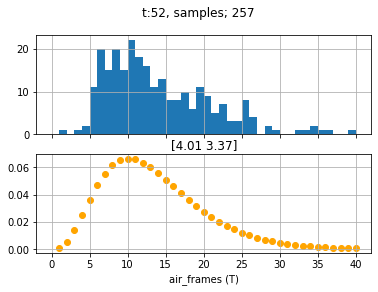

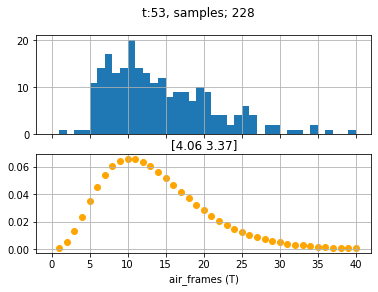

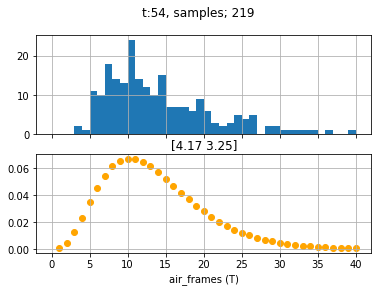

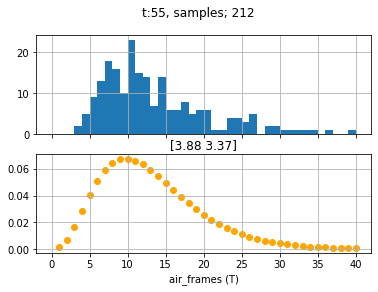

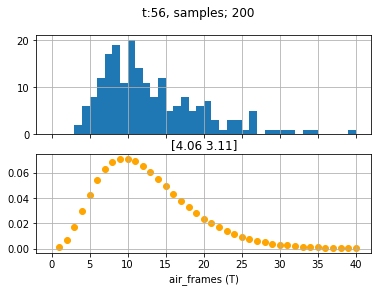

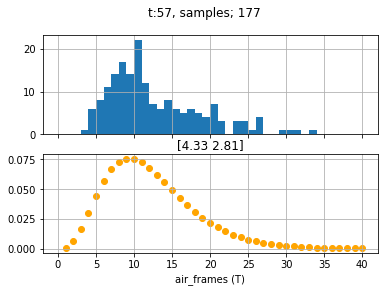

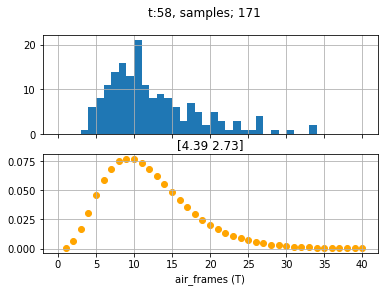

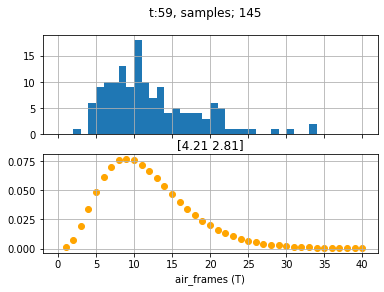

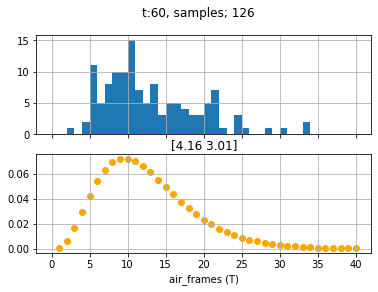

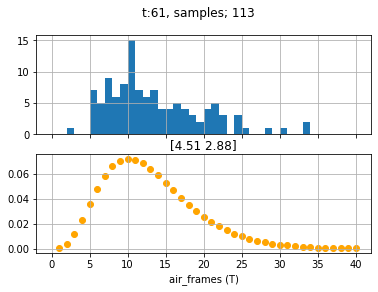

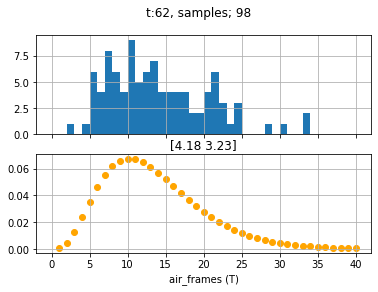

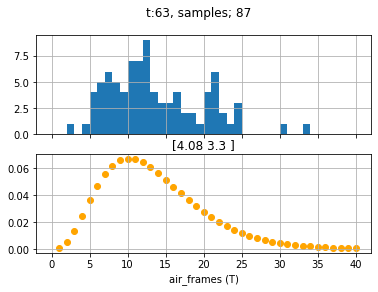

In [222]:
# P(T|t)
window_half = 2
T_gamma_df = pd.DataFrame([], columns=['T_alpha', 'T_theta'])
# executive decision: only frames 10-80 are valid for our model
for t in range(frame_min,frame_max+1):
    fig, axs = plt.subplots(2, sharex=True)
    air_frame_window = df.loc[(df.frames_to_pass >= t-window_half)&(df.frames_to_pass <= t+window_half)][['air_frames']] # not using filt_df because want to consider values outside filt_df but in window on edges
    # air_frame_window = filt_df.loc[filt_df.frames_to_pass==t]
    air_frame_window.air_frames.hist(bins=list(1*x for x in range(0, 41)), ax=axs[0])

    x = np.linspace(1, 40, 40)
    alpha, loc, theta = stats.gamma.fit(air_frame_window.air_frames.to_numpy(), floc=0)
    y1 = stats.gamma.pdf(x, a=alpha, loc=loc, scale=theta)
    axs[1].scatter(x, y1, color='orange')
    axs[1].set_title(str(np.array([alpha, theta]).round(2)))
    axs[1].set_xlabel('air_frames (T)')
    axs[1].grid(True)

    T_gamma_df = T_gamma_df.append(pd.DataFrame({'T_alpha': alpha, 'T_theta': theta}, index=[t]))
    fig.suptitle(f't:{t}, samples; {len(air_frame_window)}')
    plt.show()
    

In [224]:
T_gamma_df.rename_axis("t", inplace=True)
T_gamma_df.head() # use this for P(T|t)

,T_alpha,T_theta
t,,
10,6.466114,0.995553
11,9.328758,0.727011
12,10.131964,0.685929
13,10.025463,0.716262
14,10.007221,0.739715


In [225]:
T_gamma_df.describe().round(2)

,T_alpha,T_theta
count,54.00,54.00
mean,5.03,2.52
std,1.87,0.91
min,3.58,0.69
25%,4.05,2.04
50%,4.17,2.86
75%,4.83,3.25
max,10.13,3.56


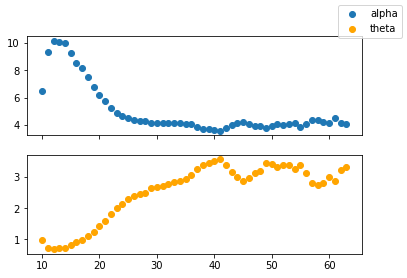

In [226]:
fig, [ax1, ax2] = plt.subplots(2, sharex=True)
ax1.scatter(T_gamma_df.index, T_gamma_df.T_alpha, label='alpha')
ax2.scatter(T_gamma_df.index, T_gamma_df.T_theta, label='theta', color='orange')
fig.legend()

In [ ]:
#GARBAGE BELOW THIS: IGNORE

0.8043057306261583

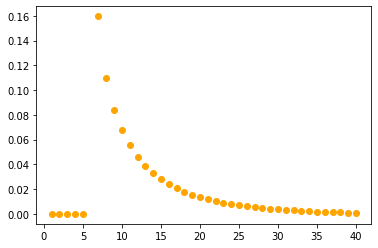

In [125]:
a, l, b = gamma_df.loc[69]
x = np.linspace(1, 40, 40)
y = stats.gamma.pdf(x, a=a, loc=l, scale=b)
plt.scatter(np.delete(x, 5), np.delete(y, 5), color='orange')
np.delete(y, 5).sum()

In [15]:
st = df.groupby(['frames_to_pass']).air_frames.describe().reindex(list(range(1,121, 1)),fill_value=np.nan)
st.head(10)

,count,mean,std,min,25%,50%,75%,max
frames_to_pass,,,,,,,,
1,7.0,7.857143,16.046065,1.0,1.0,1.0,3.5,44.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3.0,5.666667,4.041452,2.0,3.5,5.0,7.5,10.0
6,7.0,3.714286,1.704336,2.0,2.5,3.0,5.0,6.0
7,27.0,3.259259,1.872731,1.0,2.0,3.0,4.0,7.0
8,44.0,4.340909,2.596448,1.0,2.0,3.0,7.0,11.0
9,41.0,5.804878,2.441511,1.0,4.0,6.0,7.0,10.0


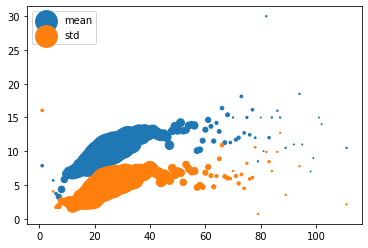

In [16]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1 = plt.scatter(st.index, st['mean'], label='mean', s=st['count'])
ax1 = plt.scatter(st.index, st['std'], label='std', s=st['count'])
plt.legend(loc='upper left')
plt.show()

In [17]:
st['w_mean'] = st['count']*st['mean']
st['w_std'] = st['count']*st['std']
st.head()

,count,mean,std,min,25%,50%,75%,max,w_mean,w_std
frames_to_pass,,,,,,,,,,
1,7.0,7.857143,16.046065,1.0,1.0,1.0,3.5,44.0,55.0,112.322452
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3.0,5.666667,4.041452,2.0,3.5,5.0,7.5,10.0,17.0,12.124356


In [18]:
bruh = st[['count', 'w_mean', 'w_std']].rolling(30, min_periods=0, center=True).sum()
bruh['r_w_mean'] = bruh.w_mean/bruh['count']
bruh['r_w_std'] = bruh.w_std/bruh['count']
print(len(bruh))
print(len(bruh.dropna()))

120
120


In [19]:
final = bruh.loc[bruh.index <= 90]


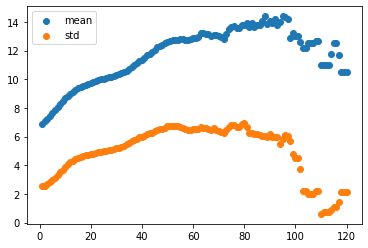

In [20]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1 = plt.scatter(bruh.index, bruh['r_w_mean'], label='mean')
ax1 = plt.scatter(bruh.index, bruh['r_w_std'], label='std')
plt.legend(loc='upper left')
plt.show()

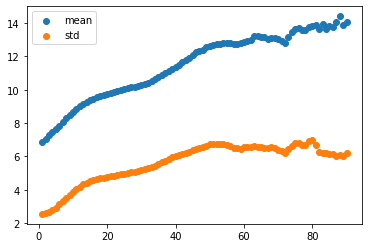

In [21]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1 = plt.scatter(final.index, final['r_w_mean'], label='mean')
ax1 = plt.scatter(final.index, final['r_w_std'], label='std')
plt.legend(loc='upper left')
plt.show()

In [22]:
bruh.tail()

,count,w_mean,w_std,r_w_mean,r_w_std
frames_to_pass,,,,,
116,4.0,50.0,4.242641,12.500000,1.060660
117,3.0,35.0,4.242641,11.666667,1.414214
118,2.0,21.0,4.242641,10.500000,2.121320
119,2.0,21.0,4.242641,10.500000,2.121320
120,2.0,21.0,4.242641,10.500000,2.121320


In [23]:
final.tail()

,count,w_mean,w_std,r_w_mean,r_w_std
frames_to_pass,,,,,
86,84.0,1156.0,515.104550,13.761905,6.132197
87,75.0,1054.0,451.850213,14.053333,6.024670
88,65.0,936.0,394.481232,14.400000,6.068942
89,57.0,791.0,342.032618,13.877193,6.000572
90,50.0,702.0,310.541878,14.040000,6.210838


In [24]:
def sinc_interp(x, s, u):
    if len(x) != len(s):
        raise ValueError('x and s must be the same length')
    
    # Find the period    
    T = s[1] - s[0]
    
    sincM = np.tile(u, (len(s), 1)) - np.tile(s[:, np.newaxis], (1, len(u)))
    y = np.dot(x, np.sinc(sincM/T))
    return y

interp_mean = sinc_interp(bruh['r_w_mean'], st.index, st.index)
interp_std = sinc_interp(bruh['r_w_std'], st.index, st.index)

print(st['mean'].size)
print(st['std'].size)
print(sma_mean.size)
print(sma_std.size)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1 = plt.scatter(st.index, interp_mean, label='mean')
ax1 = plt.scatter(st.index, interp_std, label='std')
plt.legend(loc='upper left')
plt.show()


120
120


NameError: name 'sma_mean' is not defined

In [ ]:
def sinc_interp(x, s, u):
    if len(x) != len(s):
        raise ValueError('x and s must be the same length')
    
    # Find the period    
    T = s[1] - s[0]
    
    sincM = np.tile(u, (len(s), 1)) - np.tile(s[:, np.newaxis], (1, len(u)))
    y = np.dot(x, np.sinc(sincM/T))
    return y

interp_mean = sinc_interp(sma_mean, st.index, st.index)
interp_std = sinc_interp(sma_std, st.index, st.index)

print(st['mean'].size)
print(st['std'].size)
print(sma_mean.size)
print(sma_std.size)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1 = plt.scatter(st.index, interp_mean, label='mean')
ax1 = plt.scatter(st.index, interp_std, label='std')
plt.legend(loc='upper left')
plt.show()